<a href="https://colab.research.google.com/github/arpanavvari/Amazon-Reviews-Sentimental-Analysis/blob/main/Amazon_Reviews_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import nltk
import spacy
import string
import unicodedata
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

from IPython import display
display.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')

<ipython-input-1-1fb53cc967d3>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
pip install kaggle

In [5]:
# Install Kaggle API
!pip install kaggle

# Make a directory for Kaggle configuration and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d bittlingmayer/amazonreviews -p /content

# Unzip the downloaded dataset
!unzip /content/amazonreviews.zip -d /content


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
100% 493M/493M [00:25<00:00, 16.5MB/s]
100% 493M/493M [00:25<00:00, 20.6MB/s]
Archive:  /content/amazonreviews.zip
  inflating: /content/test.ft.txt.bz2  
  inflating: /content/train.ft.txt.bz2  


In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import bz2

trainfile = bz2.BZ2File('/content/train.ft.txt.bz2','r')
testfile = bz2.BZ2File('/content/test.ft.txt.bz2','r')
lines = trainfile.readlines()
lines[0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [9]:
len(lines)


3600000

In [10]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [11]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [15]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


Data Exploration

In [14]:
train_df.describe()

,Text,Sentiment
count,1000000,1000000
unique,1000000,2
top,Stuning even for the non-gamer: This sound tra...,2
freq,1,505678


In [16]:
train_df.groupby('Sentiment').describe()

Text                                                             \
            count  unique                                                top   
Sentiment                                                                      
1          494322  494322  Buyer beware: This is a self-published book, a...   
2          505678  505678  Stuning even for the non-gamer: This sound tra...   

                
          freq  
Sentiment       
1            1  
2            1

In [17]:
train_df['length'] = train_df['Text'].apply(len)
train_df.head()
train_df.iloc[:1]

,Text,Sentiment,length
0,Stuning even for the non-gamer: This sound tra...,2,428


Data Visualization

<Axes: xlabel='Sentiment', ylabel='count'>

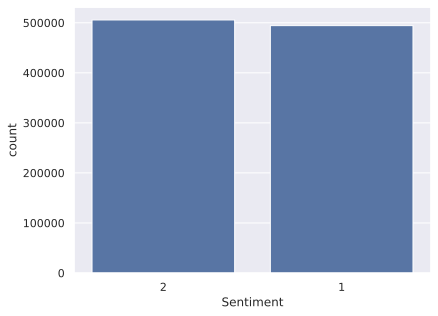

In [18]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="Sentiment", data=train_df)


<Axes: ylabel='Frequency'>

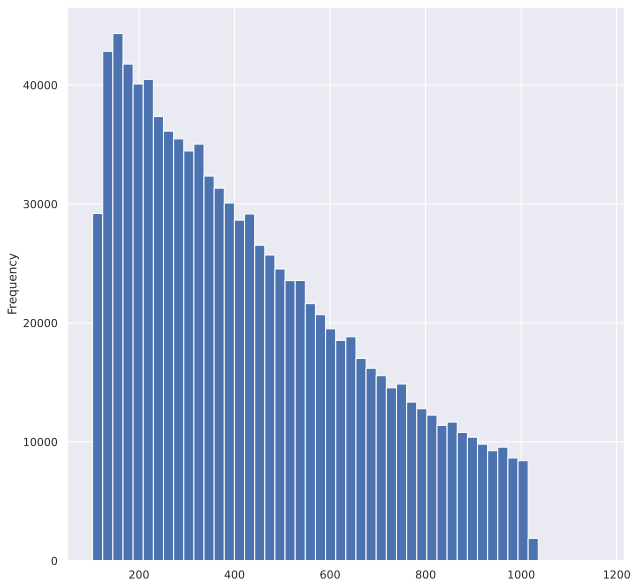

In [19]:
import seaborn as sns
train_df['length'].plot(bins=50, kind='hist',figsize = (10,10))

In [20]:
train_df.length.describe()

count    1000000.000000
mean         439.482006
std          239.716708
min          103.000000
25%          237.000000
50%          392.000000
75%          607.000000
max         1163.000000
Name: length, dtype: float64

array([<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
      dtype=object)

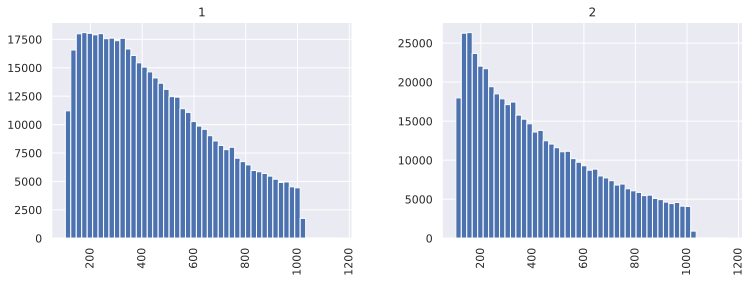

In [21]:
train_df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

Data Preprocessing

In [22]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

In [23]:
train_df['Sentiment'].value_counts()

Sentiment
1    505678
0    494322
Name: count, dtype: int64

In [24]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the non-gamer: This sound tra...,1,428,80
1,The best soundtrack ever to anything.: I'm rea...,1,511,97
2,Amazing!: This soundtrack is my favorite music...,1,768,129
3,Excellent Soundtrack: I truly like this soundt...,1,745,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,483,87


In [25]:
import string
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)

In [26]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df.shape


(1000000, 4)

In [27]:
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the nongamer This sound track...,1,428,80
1,The best soundtrack ever to anything Im readin...,1,511,97
2,Amazing This soundtrack is my favorite music o...,1,768,129
3,Excellent Soundtrack I truly like this soundtr...,1,745,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,483,87


In [28]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [29]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [30]:
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [31]:
train_df1['Sentiment'].value_counts()

Sentiment
1    39932
0    23788
Name: count, dtype: int64

In [35]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

# Define stop words
st_wd = list(text.ENGLISH_STOP_WORDS)

# Create CountVectorizer instance
c_vector = CountVectorizer(stop_words=st_wd, min_df=0.0001, lowercase=True)

# Assuming train_df1 is a DataFrame and 'Text' is the column containing the text data
c_vector.fit(train_df1['Text'].values)


CountVectorizer(min_df=0.0001,
                stop_words=['seeming', 'after', 'ourselves', 'call', 'not',
                            'hasnt', 'such', 'whenever', 'however', 'either',
                            'fifty', 'show', 'cant', 'fill', 'is', 'anything',
                            'are', 'many', 'wherein', 'his', 'somewhere', 'two',
                            'or', 'became', 'their', 'whoever', 'whither',
                            'yourselves', 'otherwise', 'in', ...])

In [39]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words)

In [40]:
len(stop_words),len(word_list)

(318, 8915)

In [41]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [42]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [43]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

Word2Vec Creation

In [45]:
from gensim.models import word2vec

# Create Word2Vec model
wv_model = word2vec.Word2Vec(sen_list, vector_size=100)


In [47]:
# Get the shape of the word vectors
wv_model.wv.vectors.shape


(14350, 100)

In [48]:
wv_model.wv.most_similar("car")

[('pair', 0.926313579082489),
 ('computer', 0.9189057350158691),
 ('replace', 0.9182115793228149),
 ('cards', 0.9172040820121765),
 ('bottle', 0.9105930328369141),
 ('lights', 0.9068207740783691),
 ('socks', 0.904972493648529),
 ('head', 0.9046740531921387),
 ('Walmart', 0.9044484496116638),
 ('filters', 0.9043501615524292)]

In [60]:
def fun(sen_list, wv_model):
    word_set = set(wv_model.wv.index_to_key)  # Corrected
    X = np.zeros([len(sen_list), 25, 100])
    c = 0
    for sen in sen_list:
        nw = 24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c, nw] = wv_model.wv[w]
                nw = nw - 1
        c = c + 1
    return X

In [62]:
# Validate the shape and type of X
print(f'Shape of X: {X.shape}')
print(f'Type of X: {type(X)}')

Shape of X: (63720, 25, 100)
Type of X: <class 'numpy.ndarray'>


In [63]:
y = train_df1['Sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [64]:
X_train.shape

(57348, 25, 100)

Model Building - Bidirectional LSTM GRU

In [65]:
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,LSTM, SimpleRNN ,GRU , Bidirectional,Input ,Concatenate, Multiply,Lambda,Reshape
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(GRU(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(GRU(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
print(lstm1.shape,' ',lstm2.shape)
lstm2 = Reshape((-1,))(lstm2)
lstm2 = Activation('sigmoid')(lstm2)
lstm2 = Reshape((-1,1))(lstm2)
mult = Multiply()([lstm1,lstm2])

add = Lambda(lambda x: K.sum(x,axis=1))(mult)
dense = Dense(100,activation='relu')(add)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

(None, 25, 200)   (None, 25, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 100)]            0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 25, 200)              362400    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 25, 1)                1218      ['bidirectional[0][0]']       
 onal)                                                                                            
                                                              

In [66]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [71]:
import numpy as np

# Ensure X_train is a NumPy array of floats
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Ensure y_train is a NumPy array of integers
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=512, callbacks=[early_stop])


Epoch 1/10
101/101 [==============================] - 106s 915ms/step - loss: 0.2039 - accuracy: 0.9151 - val_loss: 0.2609 - val_accuracy: 0.8942
Epoch 2/10
101/101 [==============================] - 85s 839ms/step - loss: 0.1901 - accuracy: 0.9210 - val_loss: 0.2684 - val_accuracy: 0.8940
Epoch 3/10
101/101 [==============================] - 82s 814ms/step - loss: 0.1796 - accuracy: 0.9263 - val_loss: 0.2721 - val_accuracy: 0.8926


Model Evaluation

In [72]:
model.evaluate(X_test, y_test, batch_size=64)

100/100 [==============================] - 7s 67ms/step - loss: 0.2572 - accuracy: 0.8991


[0.257161945104599, 0.8990897536277771]

In [73]:
scores = model.evaluate(X_test, y_test)
print("Test acc: %.2f%%" % (scores[1]*100))

200/200 [==============================] - 7s 36ms/step - loss: 0.2572 - accuracy: 0.8991
Test acc: 89.91%


In [74]:
model.evaluate(X_train, y_train, batch_size=1024)

57/57 [==============================] - 33s 581ms/step - loss: 0.1693 - accuracy: 0.9330


[0.16932456195354462, 0.9329531788825989]

In [75]:
scores = model.evaluate(X_train, y_train)
print("Train acc: %.2f%%" % (scores[1]*100))

1793/1793 [==============================] - 76s 42ms/step - loss: 0.1693 - accuracy: 0.9330
Train acc: 93.30%


Classification Matrix

In [76]:
prob_test = model.predict(X_test).reshape((-1,))
pred_test = np.array([1 if y>0.5 else 0 for y in prob_test])
y_test = y_test.astype('int')
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test))


200/200 [==============================] - 12s 56ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2367
           1       0.92      0.92      0.92      4005

    accuracy                           0.90      6372
   macro avg       0.89      0.89      0.89      6372
weighted avg       0.90      0.90      0.90      6372



Confusion Matrix

<Axes: xlabel='Predicted', ylabel='Actual'>

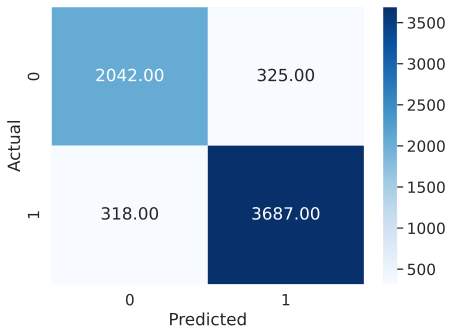

In [77]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, pred_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='.2f')

ROC-AUC and other curves

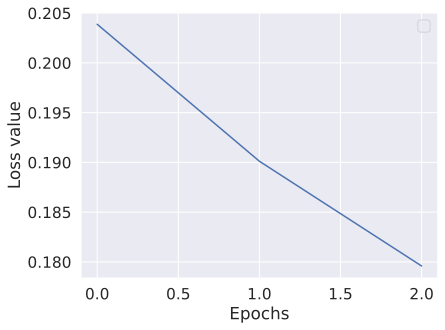

In [78]:
import matplotlib.pyplot as plt
loss_curve = hist.history['loss']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.plot(epoch_c,loss_curve)
plt.legend()
plt.show()


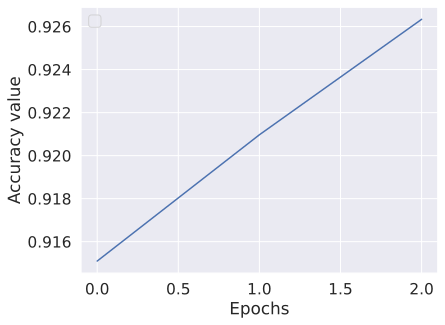

In [79]:

accuracy_curve = hist.history['accuracy']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.plot(epoch_c,accuracy_curve)
plt.legend()
plt.show()

In [80]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

200/200 [==============================] - 12s 58ms/step


In [81]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

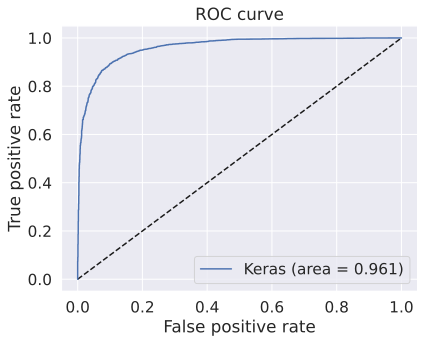

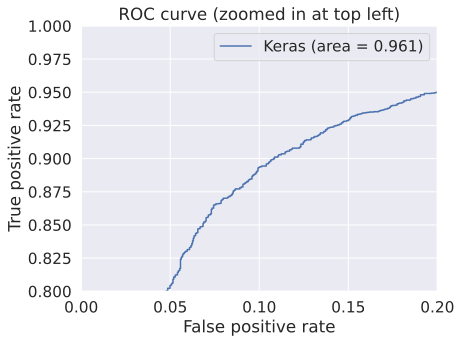

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
